In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Run this once at the top of Kaggle notebook
!pip install timm faiss-cpu sentence-transformers pydicom nibabel torchio albumentations captum pytesseract pdf2image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 1.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 62.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 39.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta

In [8]:
# Core Libraries
import os, random
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [10]:
# ML Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [12]:
# DICOM / NIfTI
import pydicom
import nibabel as nib

# Augmentation & Explainability
import albumentations as A


# OCR / PDF Parsing
import pytesseract
from pdf2image import convert_from_path

# Misc
from typing import Optional

In [13]:
import os 
BONE_PATH = '/kaggle/input/bone-fracture-dataset'
BRAIN_PATH = '/kaggle/input/brain-tumor-mri-dataset'

print('Bone dataset exists:', os.path.exists(BONE_PATH))
print('Brain dataset exists:', os.path.exists(BRAIN_PATH))

Bone dataset exists: True
Brain dataset exists: True


In [14]:
from typing import List
from PIL import Image
from pathlib import Path

def pil_from_path(path: str) -> Image.Image:
    ext = Path(path).suffix.lower()
    if ext in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
        return Image.open(path).convert('RGB')
    elif ext == '.dcm':
        ds = pydicom.dcmread(path)
        arr = ds.pixel_array.astype(float)
        arr = (255 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)).astype('uint8')
        return Image.fromarray(arr).convert('RGB')
    elif ext in ['.nii', '.nii.gz']:
        nim = nib.load(path)
        arr = nim.get_fdata()
        sl = arr.shape[2] // 2
        arr2 = arr[:, :, sl]
        arr2 = (255 * (arr2 - arr2.min()) / (arr2.max() - arr2.min() + 1e-8)).astype('uint8')
        return Image.fromarray(arr2).convert('RGB')
    else:
        return Image.open(path).convert('RGB')

def show_images(paths: List[str], cols=4, size=(12, 8)):
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=size)
    for i, p in enumerate(paths):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(pil_from_path(p))
    plt.show()

In [15]:
import os

def count_images_in_directory(directory):
    image_count = 0
    image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dcm', '.nii', '.gz'] # Add more extensions if needed
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_count += 1
    return image_count

bone_image_count = count_images_in_directory('/kaggle/input/bone-fracture-dataset')
brain_image_count_training = count_images_in_directory('/kaggle/input/brain-tumor-mri-dataset/Training')
brain_image_count_testing = count_images_in_directory('/kaggle/input/brain-tumor-mri-dataset/Testing')

print(f"Number of images in Bone dataset: {bone_image_count}")
print(f"Number of images in Brain Training dataset: {brain_image_count_training}")
print(f"Number of images in Brain Testing dataset: {brain_image_count_testing}")

Number of images in Bone dataset: 2127
Number of images in Brain Training dataset: 5712
Number of images in Brain Testing dataset: 1311


In [16]:
import pandas as pd
import os

# Gather image paths for Bone dataset
bone_images = []
bone_directory = '/kaggle/input/bone-fracture-dataset'
image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dcm', '.nii', '.gz']
for root, _, files in os.walk(bone_directory):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            bone_images.append(os.path.join(root, file))

# Bone labels
bone_rows = []
for p in bone_images:
    lab = 1 if 'fracture' in p.lower() else 0
    bone_rows.append({'filepath': p, 'label': lab, 'modality': 'xray'})
bone_df = pd.DataFrame(bone_rows)

# Gather image paths for Brain dataset (Training and Testing)
brain_images = []
brain_training_directory = '/kaggle/input/brain-tumor-mri-dataset/Training'
brain_testing_directory = '/kaggle/input/brain-tumor-mri-dataset/Testing'
for root, _, files in os.walk(brain_training_directory):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            brain_images.append(os.path.join(root, file))
for root, _, files in os.walk(brain_testing_directory):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            brain_images.append(os.path.join(root, file))


# Brain labels
brain_rows = []
for p in brain_images:
    lab = 1 if 'tumor' in p.lower() else 0
    brain_rows.append({'filepath': p, 'label': lab, 'modality': 'mri'})
brain_df = pd.DataFrame(brain_rows)

print(bone_df.head())
print(brain_df.head())

                                            filepath  label modality
0  /kaggle/input/bone-fracture-dataset/Bone fract...      1     xray
1  /kaggle/input/bone-fracture-dataset/Bone fract...      1     xray
2  /kaggle/input/bone-fracture-dataset/Bone fract...      1     xray
3  /kaggle/input/bone-fracture-dataset/Bone fract...      1     xray
4  /kaggle/input/bone-fracture-dataset/Bone fract...      1     xray
                                            filepath  label modality
0  /kaggle/input/brain-tumor-mri-dataset/Training...      1      mri
1  /kaggle/input/brain-tumor-mri-dataset/Training...      1      mri
2  /kaggle/input/brain-tumor-mri-dataset/Training...      1      mri
3  /kaggle/input/brain-tumor-mri-dataset/Training...      1      mri
4  /kaggle/input/brain-tumor-mri-dataset/Training...      1      mri


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# --- EDA Functions ---
def plot_class_distribution(data_dir, title):
    """Counts files in subdirectories and plots the distribution."""
    class_counts = {c: len(os.listdir(os.path.join(data_dir, c))) for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))}
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    plt.figure(figsize=(10, 5)); sns.barplot(x='Class', y='Count', data=df); plt.title(title); plt.show()

def show_sample_images(data_dir, title):
    """Displays one random image from each class."""
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    plt.figure(figsize=(15, 5))
    for i, class_name in enumerate(classes):
        img_path = os.path.join(data_dir, class_name, random.choice(os.listdir(os.path.join(data_dir, class_name))))
        plt.subplot(1, len(classes), i + 1); plt.imshow(Image.open(img_path)); plt.title(class_name); plt.axis('off')
    plt.suptitle(title, fontsize=16); plt.show()

# --- Training Function ---
def train_model(model, train_loader, val_loader, num_epochs=10):
    """The main training loop function."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}' + '\n' + '-'*10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            dataloader = train_loader if phase == 'train' else val_loader
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward(); optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc, best_model_wts = epoch_acc, copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'); print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

# --- Evaluation Function ---
def evaluate_model(model, val_loader, class_names, model_name):
    """Evaluates a trained model's performance."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title(f'Confusion Matrix for {model_name}'); plt.show()

--- Using device: cuda ---


--- Brain Tumor Dataset Analysis ---


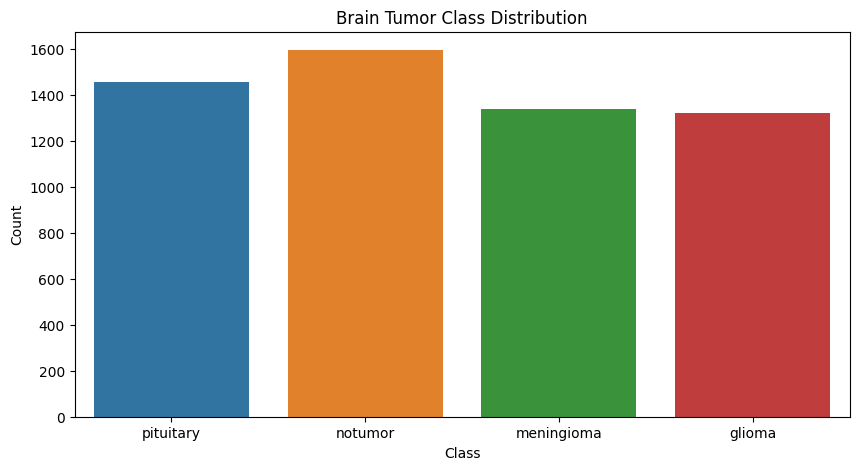

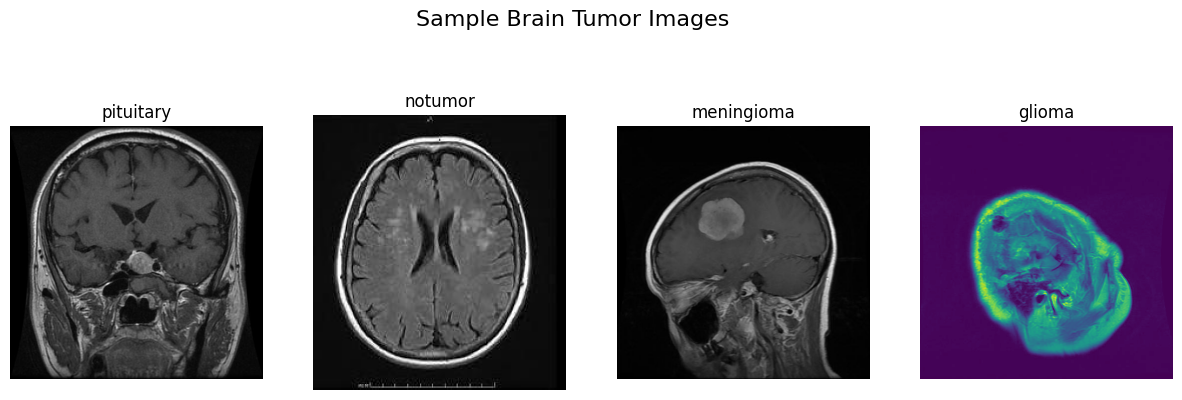

In [18]:
# BRAIN TUMOUR CLASSIFICATION 

brain_train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
print("--- Brain Tumor Dataset Analysis ---")
plot_class_distribution(brain_train_dir, 'Brain Tumor Class Distribution')
show_sample_images(brain_train_dir, 'Sample Brain Tumor Images')

In [19]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

brain_train_dataset = datasets.ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Training', transform=train_transforms)
brain_test_dataset = datasets.ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=val_transforms)

brain_train_loader = DataLoader(dataset=brain_train_dataset, batch_size=32, shuffle=True)
brain_val_loader = DataLoader(dataset=brain_test_dataset, batch_size=32, shuffle=False)

print(f"Brain tumor data loaded: {len(brain_train_dataset)} train images, {len(brain_test_dataset)} validation images.")

Brain tumor data loaded: 5712 train images, 1311 validation images.


In [20]:
# (This cell contains the updated training function)

from torch.optim.lr_scheduler import StepLR

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=15):
    """The main training loop function, now with a scheduler."""
    criterion = nn.CrossEntropyLoss()
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}' + '\n' + '-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss, running_corrects = 0.0, 0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc, best_model_wts = epoch_acc, copy.deepcopy(model.state_dict())
        
        # Step the scheduler after each epoch
        scheduler.step()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# (This cell replaces your previous A-2 cell)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # Add more augmentation
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

brain_train_dataset = datasets.ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Training', transform=train_transforms)
brain_test_dataset = datasets.ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=val_transforms)

brain_train_loader = DataLoader(dataset=brain_train_dataset, batch_size=32, shuffle=True)
brain_val_loader = DataLoader(dataset=brain_test_dataset, batch_size=32, shuffle=False)

print(f"Brain tumor data loaded with advanced augmentation.")

Brain tumor data loaded with advanced augmentation.


In [42]:
# (This cell replaces your previous A-3 cell)

print("\n--- Setting up Brain Tumor Model for Fine-Tuning ---")
brain_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# --- 1. Unfreeze the last two blocks of the model ---
# The main features of EfficientNet are in model.features
for param in brain_model.parameters():
    param.requires_grad = False

# Unfreeze from block 6 onwards
for param in brain_model.features[6:].parameters():
    param.requires_grad = True
    
# --- 2. Replace the classifier and ensure its parameters are trainable ---
num_ftrs = brain_model.classifier[1].in_features
brain_model.classifier[1] = nn.Linear(num_ftrs, 4)
# No need to set requires_grad=True, as new layers have it by default

brain_model = brain_model.to(device)

# --- 3. Set up a differential learning rate optimizer ---
# Give the classifier a higher learning rate and the unfrozen conv layers a lower one
optimizer = optim.Adam([
    {'params': brain_model.features[6:].parameters(), 'lr': 1e-5}, # Lower LR for conv layers
    {'params': brain_model.classifier.parameters(), 'lr': 1e-3}    # Higher LR for the new classifier
])

# --- 4. Set up a learning rate scheduler ---
# This will decrease the learning rate every 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

print("--- Starting Brain Tumor Model Fine-Tuning ---")
# Increase epochs for fine-tuning
trained_brain_model = train_model(brain_model, brain_train_loader, brain_val_loader, optimizer, scheduler, num_epochs=15)

torch.save(trained_brain_model.state_dict(), 'brain_tumor_finetuned_model.pth')
print("\nFine-tuned brain tumor model saved to 'brain_tumor_finetuned_model.pth'")

torch.save(trained_brain_model.state_dict(), 'brain_tumor_final_model.pth')


--- Setting up Brain Tumor Model for Fine-Tuning ---
--- Starting Brain Tumor Model Fine-Tuning ---
Epoch 1/15
----------
train Loss: 0.5606 Acc: 0.8137
val Loss: 0.4420 Acc: 0.8429
Epoch 2/15
----------
train Loss: 0.3292 Acc: 0.8831
val Loss: 0.3388 Acc: 0.8726
Epoch 3/15
----------
train Loss: 0.2937 Acc: 0.8923
val Loss: 0.2890 Acc: 0.8863
Epoch 4/15
----------
train Loss: 0.2636 Acc: 0.9067
val Loss: 0.2449 Acc: 0.9069
Epoch 5/15
----------
train Loss: 0.2196 Acc: 0.9191
val Loss: 0.2264 Acc: 0.9153
Epoch 6/15
----------
train Loss: 0.2164 Acc: 0.9196
val Loss: 0.2242 Acc: 0.9161
Epoch 7/15
----------
train Loss: 0.2052 Acc: 0.9228
val Loss: 0.2267 Acc: 0.9130
Epoch 8/15
----------
train Loss: 0.2027 Acc: 0.9280
val Loss: 0.2209 Acc: 0.9199
Epoch 9/15
----------
train Loss: 0.2068 Acc: 0.9224
val Loss: 0.2182 Acc: 0.9191
Epoch 10/15
----------
train Loss: 0.2028 Acc: 0.9263
val Loss: 0.2119 Acc: 0.9237
Epoch 11/15
----------
train Loss: 0.1914 Acc: 0.9300
val Loss: 0.2198 Acc: 0.

In [23]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

# --- Define paths and parameters ---
MODEL_PATH = 'brain_tumor_finetuned_model.pth'
TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'
NUM_CLASSES = 4

# --- Use the same device as training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Re-create the model architecture ---
# It's crucial to build the same model structure as when you trained it.
model = models.efficientnet_b0(weights=None) # Start with an untrained model structure
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

# --- 2. Load the saved weights ---
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
print("Fine-tuned model loaded successfully.")

# --- 3. Prepare the test data loader ---
# Use the validation transforms (no augmentation) for testing.
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False) # No need to shuffle for testing
class_names = test_dataset.classes

print(f"Test dataset loaded with {len(test_dataset)} images.")
print(f"Classes: {class_names}")

Using device: cuda
Fine-tuned model loaded successfully.
Test dataset loaded with 1311 images.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']



--- Overall Test Accuracy ---
Accuracy: 0.9291 (1218/1311)

--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.99      0.86      0.92       300
  meningioma       0.85      0.87      0.86       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311


--- Confusion Matrix ---


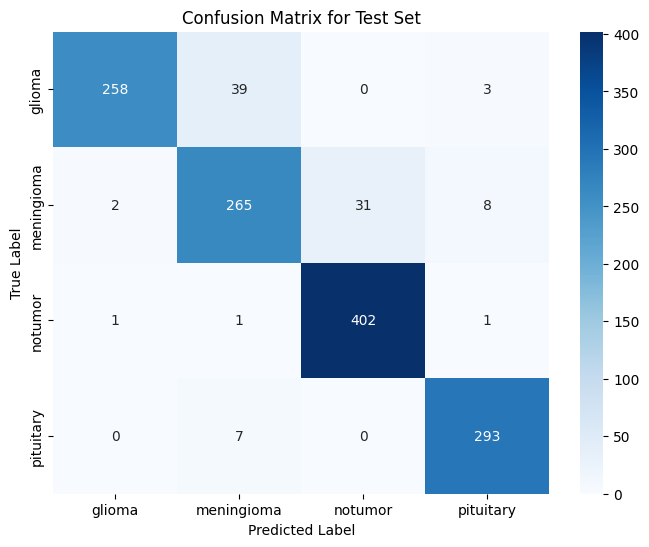

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Store predictions and true labels
y_true = []
y_pred = []

# Disable gradient calculations for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get the predicted class (the one with the highest probability)
        _, preds = torch.max(outputs, 1)
        
        # Append batch results to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 1. Calculate and Print Overall Test Accuracy ---
correct_predictions = sum(p == t for p, t in zip(y_pred, y_true))
total_samples = len(y_true)
accuracy = correct_predictions / total_samples
print(f"\n--- Overall Test Accuracy ---")
print(f"Accuracy: {accuracy:.4f} ({correct_predictions}/{total_samples})")

# --- 2. Display the Classification Report ---
# This shows precision, recall, and F1-score for each class.
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 3. Display the Confusion Matrix ---
# This visualizes where the model is making correct and incorrect predictions.
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

In [27]:
# SCATTER PLOT - BRAIN TUMOR CLASSIFICATION

import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def extract_image_features(data_dir, sample_size=200):
    """
    Extracts mean brightness and contrast from a sample of images in each class.
    """
    features = []
    print("Extracting features from images...")
    
    # Loop through each class folder (glioma, meningioma, etc.)
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Get a random sample of image files from the class
        image_files = os.listdir(class_path)
        sample_files = np.random.choice(image_files, min(len(image_files), sample_size), replace=False)
        
        # Process each sampled image
        for image_file in sample_files:
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path).convert('L') as img: # Convert to grayscale for intensity calculation
                image_array = np.array(img)
                brightness = image_array.mean()
                contrast = image_array.std()
                features.append({
                    'class': class_name,
                    'brightness': brightness,
                    'contrast': contrast
                })
    print("Feature extraction complete.")
    return pd.DataFrame(features)

# --- Define the path to your training data ---
brain_train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

# --- Create the DataFrame ---
features_df = extract_image_features(brain_train_dir)
print("\nSample of extracted features:")
print(features_df.head())

Extracting features from images...
Feature extraction complete.

Sample of extracted features:
       class  brightness   contrast
0  pituitary   48.436638  37.338793
1  pituitary   45.396164  39.277103
2  pituitary   54.094646  43.534624
3  pituitary   54.899620  41.324379
4  pituitary   49.563782  31.560781


In [29]:
# --- Check the distribution of classes in the DataFrame ---
# .value_counts() is the best way to see the count for each category.
class_distribution = features_df['class'].value_counts()

print("--- Number of Samples Extracted per Class ---")
print(class_distribution)

# You can also view a random sample from the DataFrame to see other classes
print("\n--- A Random Sample from the DataFrame ---")
print(features_df.sample(5))

--- Number of Samples Extracted per Class ---
class
pituitary     200
notumor       200
meningioma    200
glioma        200
Name: count, dtype: int64

--- A Random Sample from the DataFrame ---
          class  brightness   contrast
590  meningioma   40.571125  43.666515
675      glioma   45.773857  39.704595
241     notumor   68.858162  68.839081
137   pituitary   50.207340  39.952310
4     pituitary   49.563782  31.560781


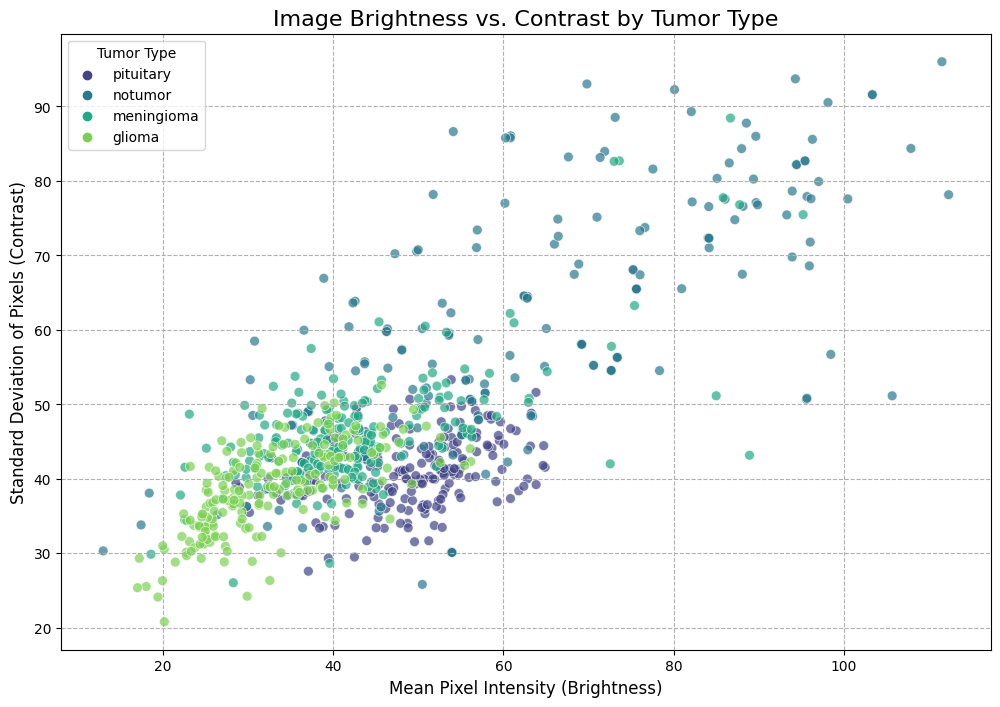

In [30]:
# --- Create the Scatter Plot ---
plt.figure(figsize=(12, 8))

# Use seaborn to create a scatter plot colored by tumor class
sns.scatterplot(
    data=features_df,
    x='brightness',
    y='contrast',
    hue='class',       # Color points based on the 'class' column
    palette='viridis', # Use a nice color scheme
    alpha=0.7,         # Set transparency for better visibility of overlapping points
    s=50               # Set the size of the points
)

# --- Add Labels and Title for Clarity ---
plt.title('Image Brightness vs. Contrast by Tumor Type', fontsize=16)
plt.xlabel('Mean Pixel Intensity (Brightness)', fontsize=12)
plt.ylabel('Standard Deviation of Pixels (Contrast)', fontsize=12)
plt.legend(title='Tumor Type')
plt.grid(True, linestyle='--')

# --- Display the Plot ---
plt.show()

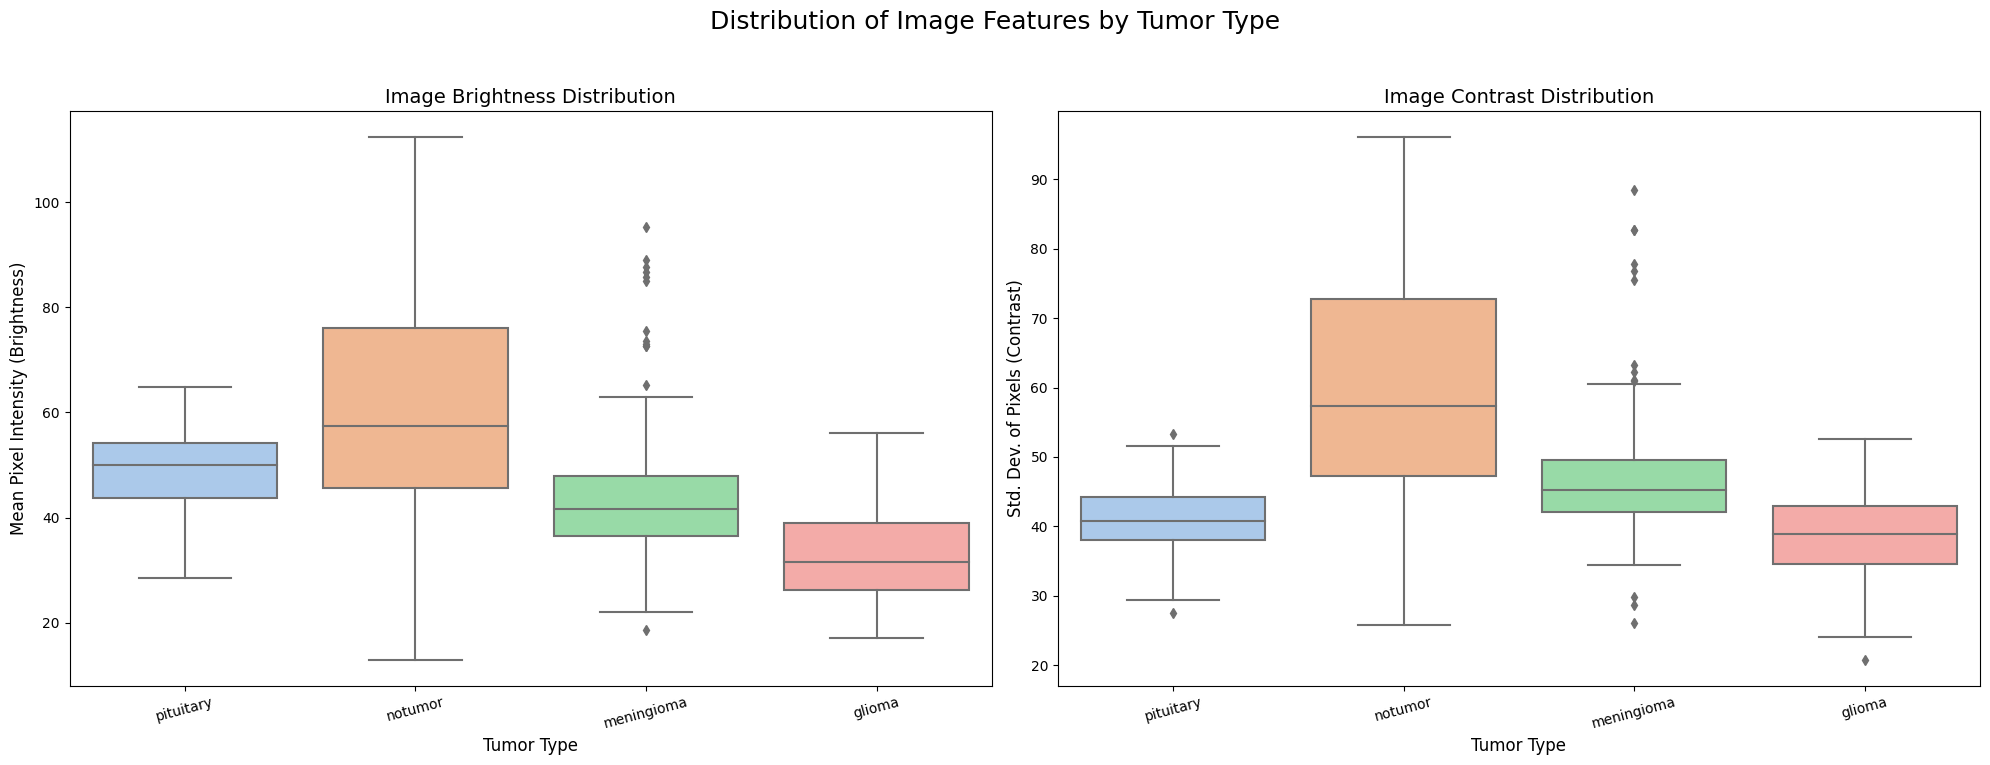

In [31]:
# BOX PLOT - BRAIN TUMOR CLASSIFICATION

import seaborn as sns
import matplotlib.pyplot as plt

# --- Create a figure with two subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Distribution of Image Features by Tumor Type', fontsize=18)

# --- Box Plot for Brightness ---
sns.boxplot(
    ax=ax1,
    data=features_df,
    x='class',
    y='brightness',
    palette='pastel'
)
ax1.set_title('Image Brightness Distribution', fontsize=14)
ax1.set_xlabel('Tumor Type', fontsize=12)
ax1.set_ylabel('Mean Pixel Intensity (Brightness)', fontsize=12)
ax1.tick_params(axis='x', rotation=15) # Rotate labels slightly for better fit

# --- Box Plot for Contrast ---
sns.boxplot(
    ax=ax2,
    data=features_df,
    x='class',
    y='contrast',
    palette='pastel'
)
ax2.set_title('Image Contrast Distribution', fontsize=14)
ax2.set_xlabel('Tumor Type', fontsize=12)
ax2.set_ylabel('Std. Dev. of Pixels (Contrast)', fontsize=12)
ax2.tick_params(axis='x', rotation=15)

# --- Display the Plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

In [34]:
#SWARMPLOT - BRAIN TUMOR CLASSIFICATION

import os
from PIL import Image
import numpy as np
import pandas as pd

def extract_image_features(data_dir, sample_size=200):
    """
    Extracts mean brightness and contrast from a sample of images in each class.
    """
    features = []
    print("Extracting features from images...")
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        image_files = os.listdir(class_path)
        sample_files = np.random.choice(image_files, min(len(image_files), sample_size), replace=False)
        
        for image_file in sample_files:
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path).convert('L') as img:
                image_array = np.array(img)
                brightness = image_array.mean()
                contrast = image_array.std()
                features.append({
                    'class': class_name,
                    'brightness': brightness,
                    'contrast': contrast
                })
    print("Feature extraction complete.")
    return pd.DataFrame(features)

# --- Define the path and create the DataFrame ---
brain_train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
features_df = extract_image_features(brain_train_dir)

Extracting features from images...
Feature extraction complete.


/tmp/ipykernel_37/624393517.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_37/624393517.py:23: Future

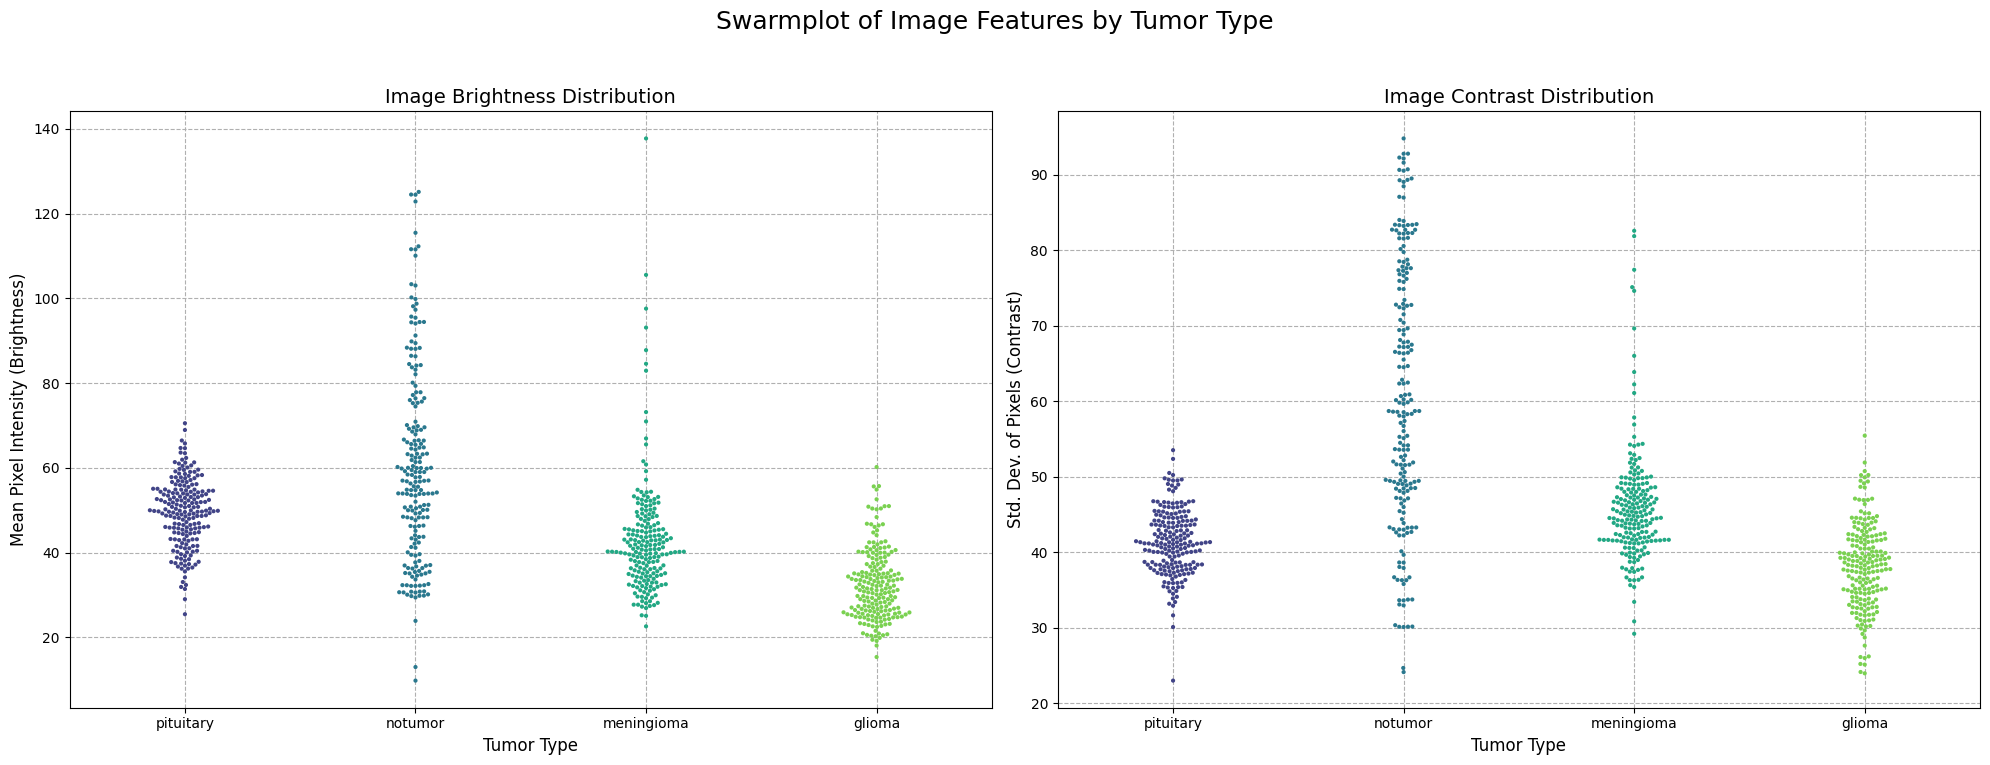

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create a figure with two subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Swarmplot of Image Features by Tumor Type', fontsize=18)

# --- Swarmplot for Brightness ---
sns.swarmplot(
    ax=ax1,
    data=features_df,
    x='class',
    y='brightness',
    palette='viridis',
    s=3  # Use smaller dots for a cleaner look
)
ax1.set_title('Image Brightness Distribution', fontsize=14)
ax1.set_xlabel('Tumor Type', fontsize=12)
ax1.set_ylabel('Mean Pixel Intensity (Brightness)', fontsize=12)
ax1.grid(True, linestyle='--')

# --- Swarmplot for Contrast ---
sns.swarmplot(
    ax=ax2,
    data=features_df,
    x='class',
    y='contrast',
    palette='viridis',
    s=3
)
ax2.set_title('Image Contrast Distribution', fontsize=14)
ax2.set_xlabel('Tumor Type', fontsize=12)
ax2.set_ylabel('Std. Dev. of Pixels (Contrast)', fontsize=12)
ax2.grid(True, linestyle='--')

# --- Display the Plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

In [37]:
# PIE CHART - BRAIN TUMOR CLASSIFICATION
import os
import matplotlib.pyplot as plt

# --- Define the path to your training data ---
brain_train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

# --- Count the number of images in each class folder ---
class_counts = {}
for class_name in os.listdir(brain_train_dir):
    class_path = os.path.join(brain_train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# --- Extract labels (class names) and sizes (the counts) ---
labels = list(class_counts.keys())
sizes = list(class_counts.values())

print("--- Image Counts per Class ---")
for label, size in zip(labels, sizes):
    print(f"{label}: {size} images")

--- Image Counts per Class ---
pituitary: 1457 images
notumor: 1595 images
meningioma: 1339 images
glioma: 1321 images


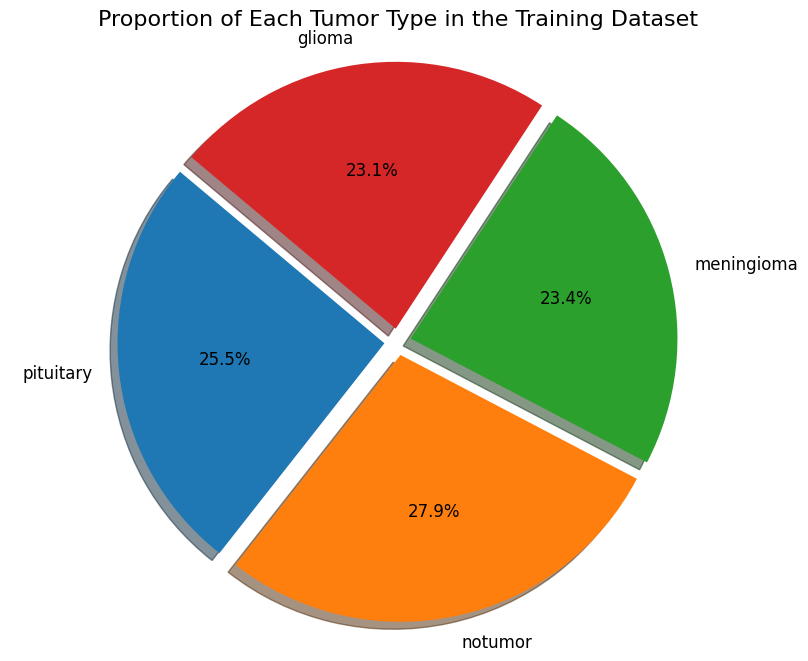

In [39]:
# --- Create the Pie Chart ---
plt.figure(figsize=(10, 8))

# The 'explode' parameter slightly separates the wedges for better visibility
explode = (0.05, 0.05, 0.05, 0.05) 

# The 'autopct' parameter formats the percentage display on each wedge
plt.pie(
    sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%', # Format for one decimal place percentage
    shadow=True, 
    startangle=140,
    textprops={'fontsize': 12}
)

# --- Add Title and ensure it's a circle ---
plt.title('Proportion of Each Tumor Type in the Training Dataset', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# --- Display the Plot ---
plt.show()

In [40]:
# HISTOGRAM - BRAIN TUMOR CLASSIFICATION

import os
from PIL import Image
import numpy as np
import pandas as pd

def extract_image_features(data_dir, sample_size=200):
    """
    Extracts mean brightness and contrast from a sample of images in each class.
    """
    features = []
    print("Extracting features from images...")
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        image_files = os.listdir(class_path)
        sample_files = np.random.choice(image_files, min(len(image_files), sample_size), replace=False)
        
        for image_file in sample_files:
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path).convert('L') as img:
                image_array = np.array(img)
                brightness = image_array.mean()
                contrast = image_array.std()
                features.append({
                    'class': class_name,
                    'brightness': brightness,
                    'contrast': contrast
                })
    print("Feature extraction complete.")
    return pd.DataFrame(features)

# --- Define the path and create the DataFrame ---
brain_train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
features_df = extract_image_features(brain_train_dir)

Extracting features from images...
Feature extraction complete.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

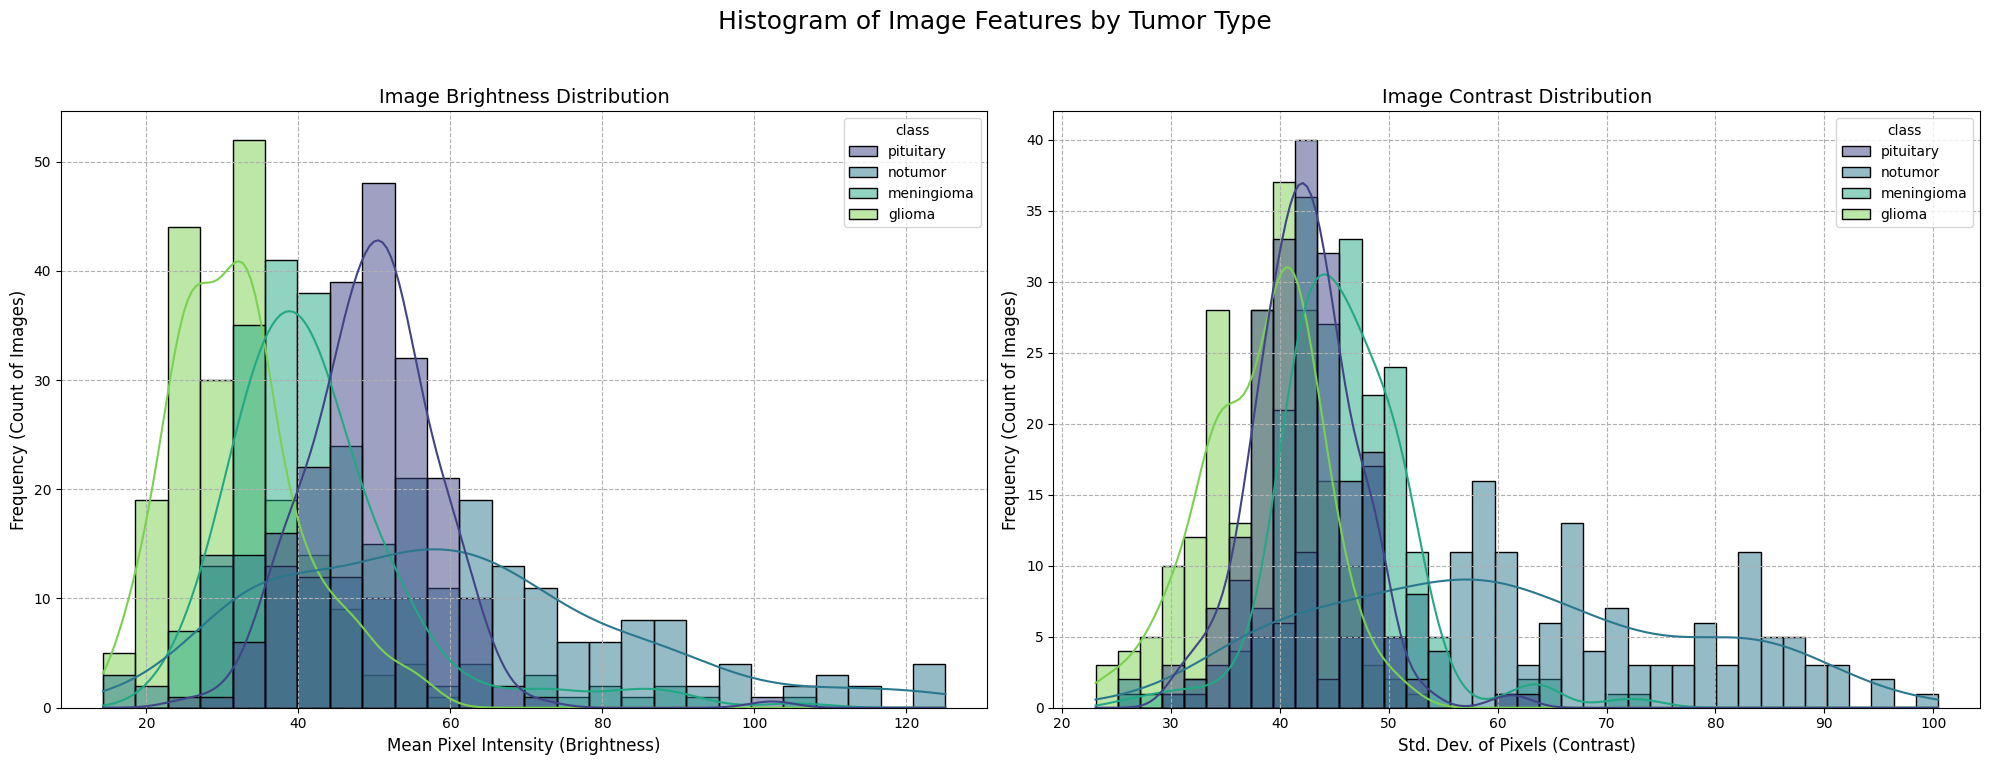

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create a figure with two subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Histogram of Image Features by Tumor Type', fontsize=18)

# --- Histogram for Brightness ---
# The 'hue' parameter creates separate, stacked bars for each tumor class
sns.histplot(
    ax=ax1,
    data=features_df,
    x='brightness',
    hue='class',       # Color bars based on the tumor class
    kde=True,          # Add a Kernel Density Estimate curve for a smooth distribution line
    palette='viridis'
)
ax1.set_title('Image Brightness Distribution', fontsize=14)
ax1.set_xlabel('Mean Pixel Intensity (Brightness)', fontsize=12)
ax1.set_ylabel('Frequency (Count of Images)', fontsize=12)
ax1.grid(True, linestyle='--')

# --- Histogram for Contrast ---
sns.histplot(
    ax=ax2,
    data=features_df,
    x='contrast',
    hue='class',
    kde=True,
    palette='viridis'
)
ax2.set_title('Image Contrast Distribution', fontsize=14)
ax2.set_xlabel('Std. Dev. of Pixels (Contrast)', fontsize=12)
ax2.set_ylabel('Frequency (Count of Images)', fontsize=12)
ax2.grid(True, linestyle='--')

# --- Display the Plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

---------------------------------------------------------------------------------------------- BRAIN TUMOUR CLASSIFICATION ----------------------------------------------------------------------------------------------------

--- Bone Fracture Dataset Analysis ---


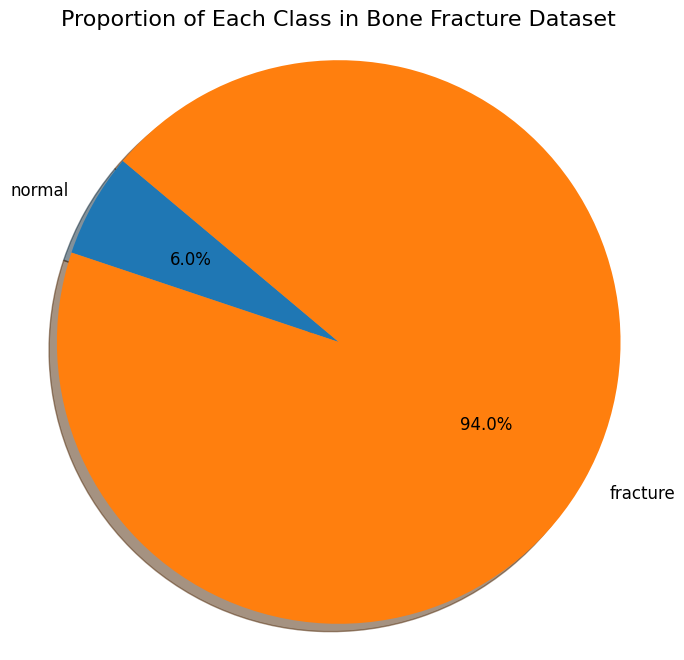

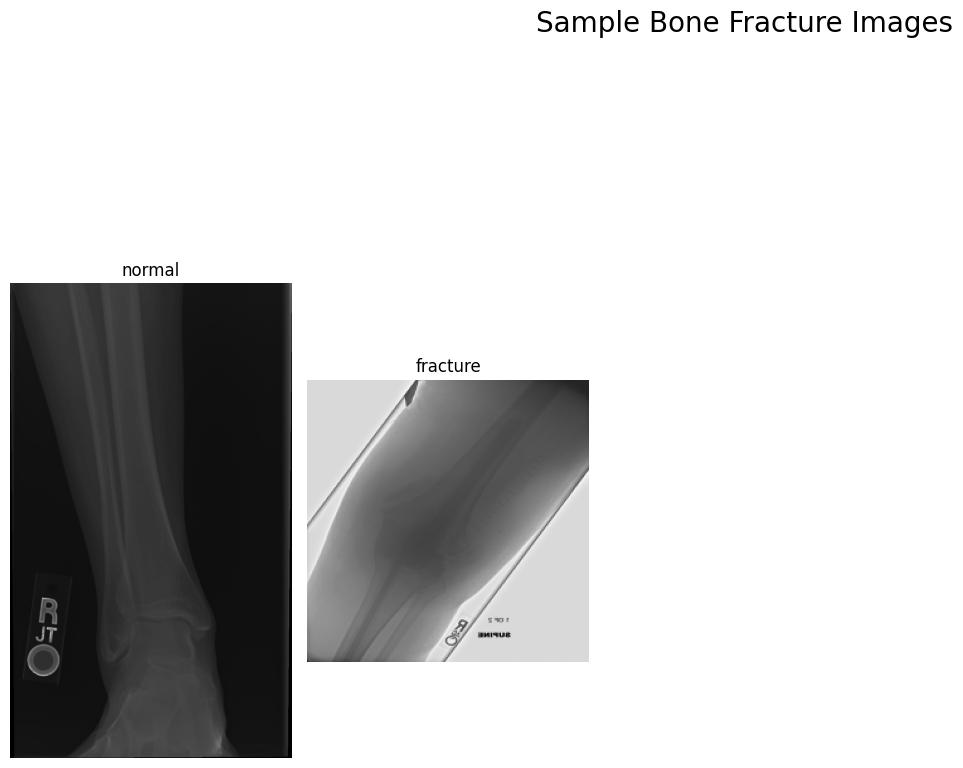

In [6]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- Define the path to the bone fracture training data ---
# Note: You might need to adjust this path based on your environment
bone_train_dir = '/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset'

# --- 1. Pie Chart for Class Distribution ---
print("--- Bone Fracture Dataset Analysis ---")
# Check if the directory exists to avoid errors
if os.path.exists(bone_train_dir):
    bone_class_counts = {c: len(os.listdir(os.path.join(bone_train_dir, c))) for c in os.listdir(bone_train_dir) if os.path.isdir(os.path.join(bone_train_dir, c))}
    labels = list(bone_class_counts.keys())
    sizes = list(bone_class_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title('Proportion of Each Class in Bone Fracture Dataset', fontsize=16)
    plt.axis('equal')
    plt.show()

    # --- Definition of the missing function ---
    def show_sample_images(directory, title_text):
        """
        Displays one random sample image from each subdirectory (class).
        """
        plt.figure(figsize=(15, 10))
        plt.suptitle(title_text, fontsize=20)
        
        # Get the list of class directories
        class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        
        # Determine the grid size for subplots
        num_classes = len(class_dirs)
        num_cols = 5
        num_rows = (num_classes + num_cols - 1) // num_cols # Calculate rows needed
        
        for i, class_name in enumerate(class_dirs):
            class_path = os.path.join(directory, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            
            if image_files: # Ensure the directory is not empty
                # Pick one random image file
                random_image_file = random.choice(image_files)
                image_path = os.path.join(class_path, random_image_file)
                
                # Read and display the image
                img = mpimg.imread(image_path)
                plt.subplot(num_rows, num_cols, i + 1)
                plt.imshow(img, cmap='gray') # Use cmap='gray' for grayscale images
                plt.title(class_name)
                plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- 2. Show Sample Images (Now the function is defined) ---
    show_sample_images(bone_train_dir, 'Sample Bone Fracture Images')

else:
    print(f"Error: The directory '{bone_train_dir}' does not exist. Please check the path.")

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# --- Assume bone_train_dir is defined from the previous step ---
# Example path: bone_train_dir = '/path/to/your/dataset'
# Make sure this variable is set correctly before running this code.
# For example:
bone_train_dir = '/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset'


# --- Define Advanced Transforms ---
# Use a powerful automatic augmentation policy for training
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),      # Use 300x300 for EfficientNet-B3
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentation for validation
val_transforms = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load and Split the Dataset ---
full_bone_dataset = datasets.ImageFolder(root=bone_train_dir, transform=train_transforms)

# Set a seed for reproducibility
torch.manual_seed(42)
train_size = int(0.8 * len(full_bone_dataset))
val_size = len(full_bone_dataset) - train_size
bone_train_dataset, bone_val_dataset = random_split(full_bone_dataset, [train_size, val_size])

# IMPORTANT: Apply the non-augmented transforms to the validation subset
# We need to create a new dataset object for validation with the correct transforms,
# as modifying it in-place can be tricky and lead to unexpected behavior.
# A cleaner way is to handle transforms within the dataset's __getitem__ method,
# but for this structure, let's create a wrapper or re-instantiate.
# However, the original approach has a subtle issue. Let's correct it properly.
# The `random_split` creates subsets that reference the original dataset, including its transform.
# The line `bone_val_dataset.dataset.transform = val_transforms` incorrectly changes the transform
# for the *entire* original dataset, which affects the training set too.

# The correct way is to have two different dataset objects.
# But for a quick fix that works with your current structure, we can do this:
# Re-load the dataset for validation without augmentations.
val_full_dataset = datasets.ImageFolder(root=bone_train_dir, transform=val_transforms)
_, bone_val_dataset_correct = random_split(val_full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))


# --- Create DataLoaders ---
# Use a smaller batch size for a larger model
bone_train_loader = DataLoader(dataset=bone_train_dataset, batch_size=16, shuffle=True)
bone_val_loader = DataLoader(dataset=bone_val_dataset_correct, batch_size=16, shuffle=False)

print(f"Bone fracture data loaded and split: {len(bone_train_dataset)} train images, {len(bone_val_dataset_correct)} validation images.")

Bone fracture data loaded and split: 1701 train images, 426 validation images.


Using device: cuda

--- Setting up FINAL Bone Fracture Model (EfficientNet-B3) ---


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 173MB/s]


--- Starting FINAL Training with Early Stopping ---
Epoch 1/30 | Train Loss: 0.2481 | Train Acc: 0.9224 | Val Loss: 0.0809 | Val Acc: 0.9859
Validation loss improved. Saving model.
Epoch 2/30 | Train Loss: 0.0862 | Train Acc: 0.9747 | Val Loss: 0.0262 | Val Acc: 0.9930
Validation loss improved. Saving model.
Epoch 3/30 | Train Loss: 0.0435 | Train Acc: 0.9894 | Val Loss: 0.0041 | Val Acc: 1.0000
Validation loss improved. Saving model.
Epoch 4/30 | Train Loss: 0.0293 | Train Acc: 0.9924 | Val Loss: 0.0057 | Val Acc: 1.0000
Validation loss did not improve. Patience: 1/5
Epoch 5/30 | Train Loss: 0.0358 | Train Acc: 0.9877 | Val Loss: 0.0064 | Val Acc: 0.9953
Validation loss did not improve. Patience: 2/5
Epoch 6/30 | Train Loss: 0.0286 | Train Acc: 0.9894 | Val Loss: 0.0068 | Val Acc: 0.9953
Validation loss did not improve. Patience: 3/5
Epoch 7/30 | Train Loss: 0.0256 | Train Acc: 0.9929 | Val Loss: 0.0027 | Val Acc: 1.0000
Validation loss improved. Saving model.
Epoch 8/30 | Train Loss:

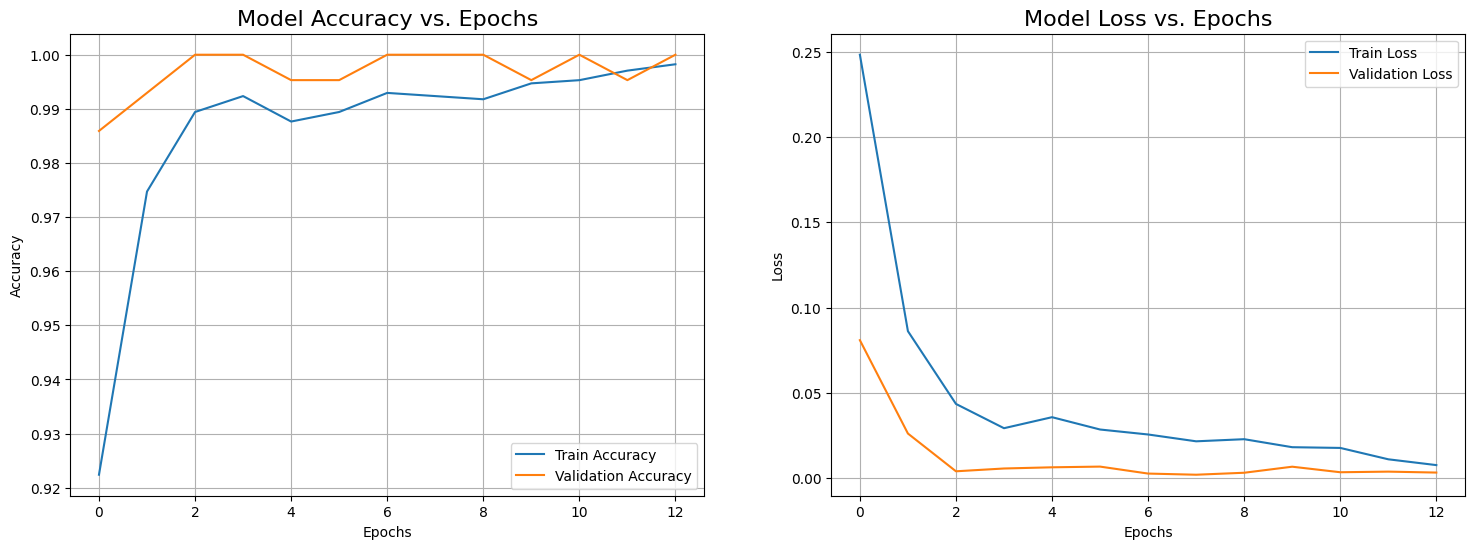

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import copy # To save the best model state

# --- Assume DataLoaders are defined from the previous step ---
# bone_train_loader, bone_val_loader

# --- Define the device (use GPU if available) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- (Function Definition) Training with Early Stopping ---
def train_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, num_epochs, patience):
    """
    Trains a model with a mechanism to stop early if validation loss doesn't improve.
    """
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # --- Validation Phase ---
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_predictions += torch.sum(preds == labels.data)
                val_total_predictions += labels.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions.double() / val_total_predictions
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

        # Update the learning rate scheduler
        scheduler.step()

        # Early stopping check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_wts)
                return model, history

    model.load_state_dict(best_model_wts)
    return model, history

# --- (Function Definition) Plotting Training History ---
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy vs. Epochs', fontsize=16)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss vs. Epochs', fontsize=16)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()


# --- Setup the Advanced Model (EfficientNet-B3) ---
print("\n--- Setting up FINAL Bone Fracture Model (EfficientNet-B3) ---")
bone_model = models.efficientnet_b3(weights='IMAGENET1K_V1')

# Set all layers to be trainable
for param in bone_model.parameters():
    param.requires_grad = True

# Replace the final classifier for our 2 classes ('fractured', 'not fractured')
num_ftrs = bone_model.classifier[1].in_features
bone_model.classifier[1] = nn.Linear(num_ftrs, 2) # Assuming 2 classes
bone_model = bone_model.to(device)

# Define optimizer and scheduler
optimizer = optim.AdamW(bone_model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# --- Start Training with Early Stopping ---
print("--- Starting FINAL Training with Early Stopping ---")
trained_bone_model, bone_history = train_with_early_stopping(
    bone_model, 
    bone_train_loader, 
    bone_val_loader, 
    optimizer, 
    scheduler, 
    num_epochs=30,
    patience=5 # Stop if validation loss doesn't improve for 5 consecutive epochs
)

# --- Save the best model ---
torch.save(trained_bone_model.state_dict(), 'bone_fracture_final_model.pth')
print("\nFinal bone fracture model saved to 'bone_fracture_final_model.pth'")

# --- Plot the history to check for overfitting ---
plot_training_history(bone_history)

Using device: cuda
Loading model from: bone_fracture_final_model.pth
Using test data from: /kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset

Test dataset loaded: 2127 images. Classes: ['fracture', 'normal']

🔬 FINAL TEST SET EVALUATION

--- Classification Report ---
              precision    recall  f1-score   support

    fracture       1.00      1.00      1.00      2000
      normal       1.00      1.00      1.00       127

    accuracy                           1.00      2127
   macro avg       1.00      1.00      1.00      2127
weighted avg       1.00      1.00      1.00      2127


--- Confusion Matrix ---


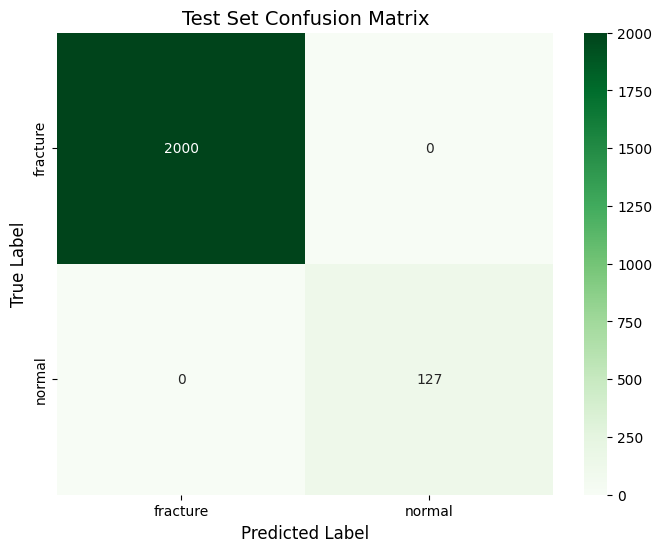


--- Visualizing Sample Predictions ---


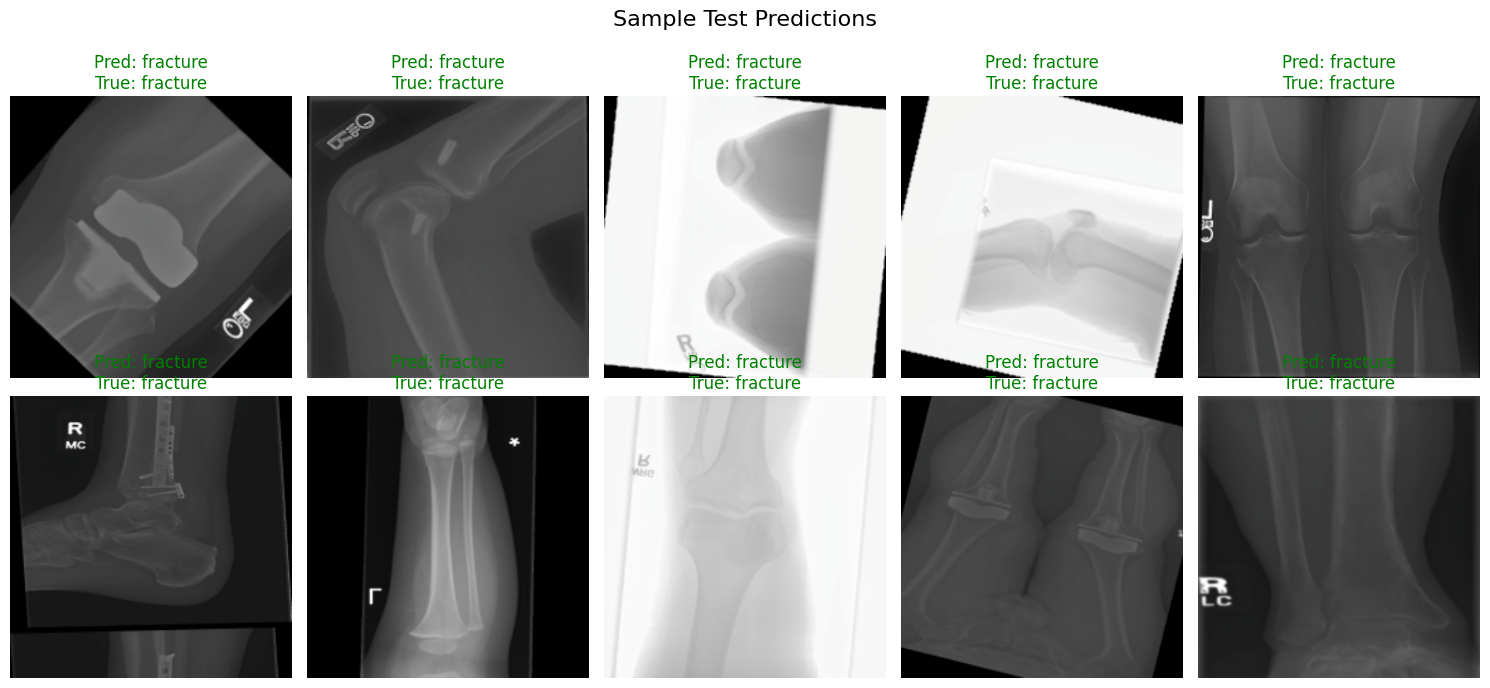

In [6]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
import os

# --- 1. Configuration and Setup ---
# Define the path to your test dataset and your saved model
TEST_DIR = '/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset' # IMPORTANT: Change this to your test data path
MODEL_PATH = 'bone_fracture_final_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print(f"Loading model from: {MODEL_PATH}")
print(f"Using test data from: {TEST_DIR}")


# --- 2. Load the Trained Model ---
# First, re-create the model's architecture
def create_model():
    model = models.efficientnet_b3(weights=None) # Use weights=None as we will load our own
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(num_ftrs, 2) # Adjust to the number of your classes
    )
    return model

# Instantiate the model and load the saved weights
model = create_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval() # Set the model to evaluation mode


# --- 3. Prepare the Test Dataloader ---
# The transformations for the test set should be the same as for the validation set
test_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False) # No need to shuffle for testing
class_names = test_dataset.classes
print(f"\nTest dataset loaded: {len(test_dataset)} images. Classes: {class_names}")


# --- 4. Get Predictions for the Entire Test Set ---
all_labels = []
all_preds = []

with torch.no_grad(): # Deactivates autograd, speeding up computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. Display Evaluation Metrics ---
print("\n" + "="*50)
print("🔬 FINAL TEST SET EVALUATION")
print("="*50)

# a) Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

# b) Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Test Set Confusion Matrix', fontsize=14)
plt.show()


# --- 6. Visualize Predictions on Sample Images ---
def visualize_predictions(model, loader, class_names, num_images=10):
    """Shows a grid of images with their predicted and true labels."""
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    # Get a random batch of images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 7))
    plt.suptitle("Sample Test Predictions", fontsize=16)

    for i in range(len(images)):
        if images_so_far >= num_images:
            break
        images_so_far += 1
        
        ax = plt.subplot(2, num_images // 2, images_so_far)
        
        # Un-normalize and display image
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.axis('off')

        predicted_class = class_names[preds[i]]
        true_class = class_names[labels[i]]

        # Set title color based on correctness
        if predicted_class == true_class:
            color = "green"
        else:
            color = "red"
            
        ax.set_title(f'Pred: {predicted_class}\nTrue: {true_class}', color=color)

    model.train(mode=was_training)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\n--- Visualizing Sample Predictions ---")
visualize_predictions(model, test_loader, class_names)

Data collected for 2127 images.

--- Generating Pie Chart ---


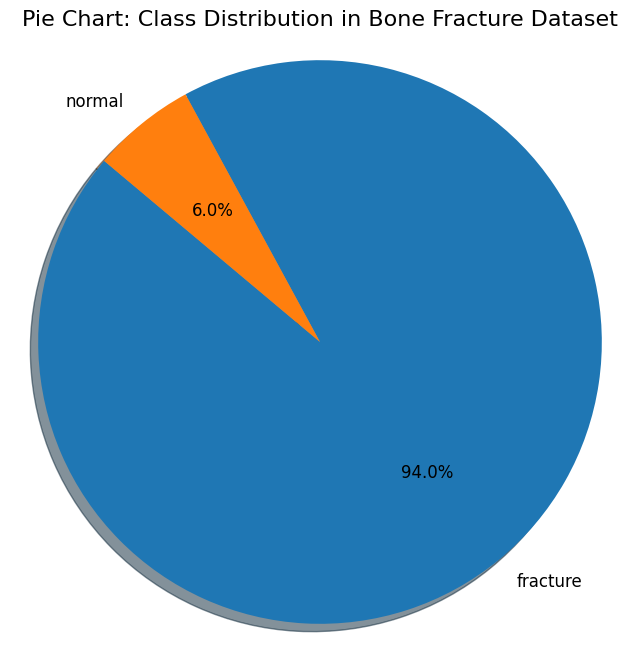


--- Generating Histogram ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


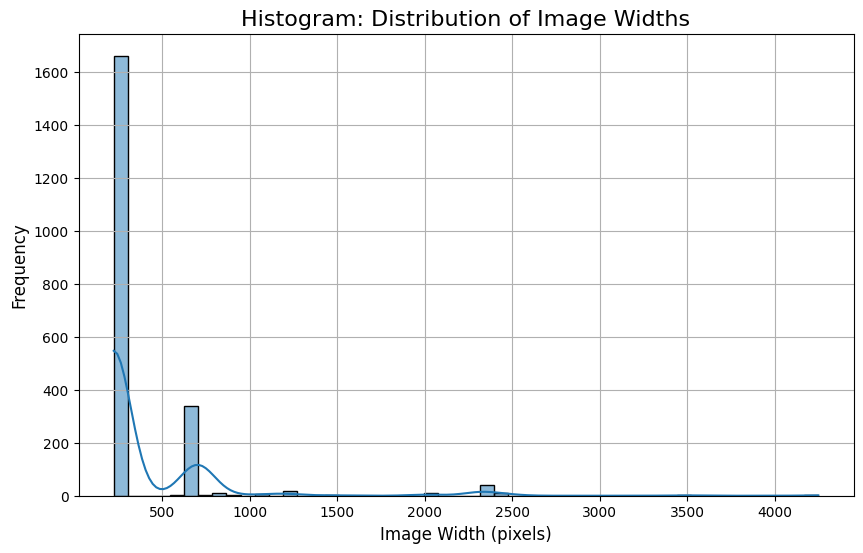


--- Generating Scatter Plot ---


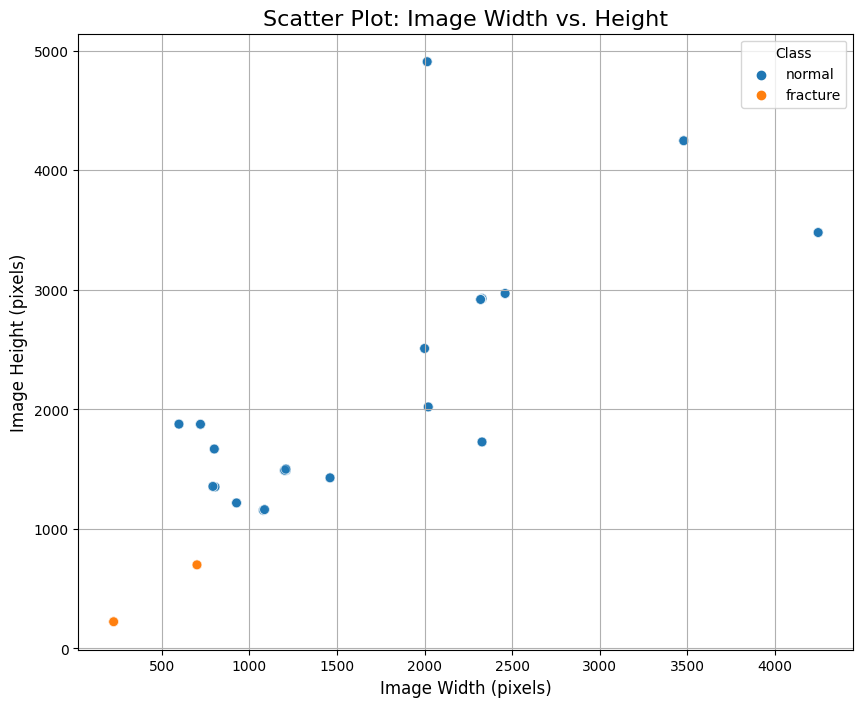


--- Generating Joint Plot ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

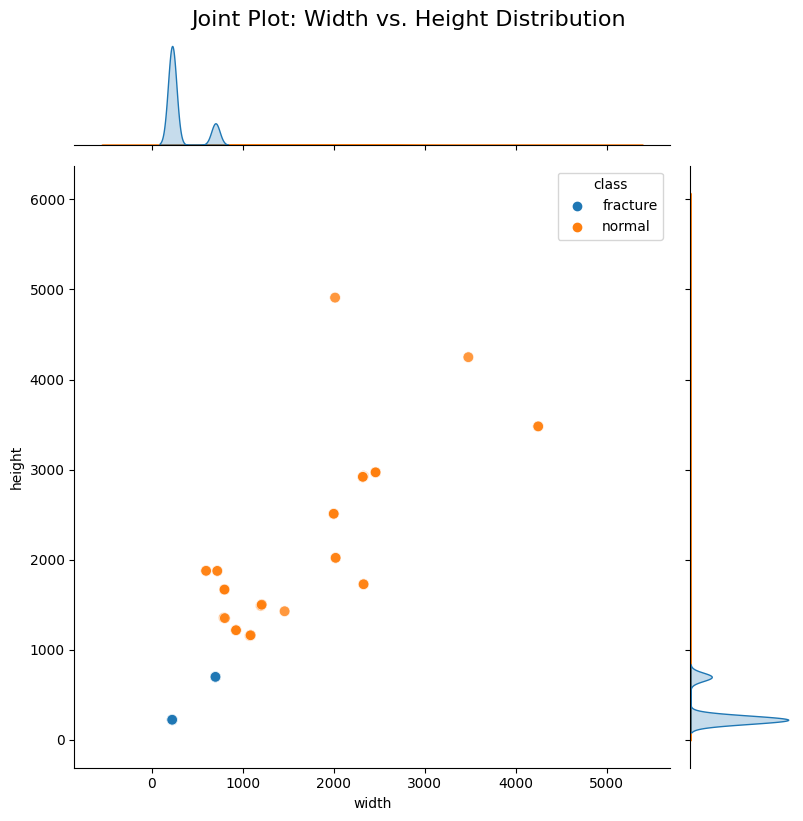

In [7]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Configuration ---
# Update this path to point to your dataset's root directory
DATASET_DIR = '/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset'

# --- 2. Data Collection ---
# We need to iterate through the images to get their dimensions for some plots.
def get_image_data(directory):
    """
    Walks through the dataset directory to collect image paths,
    class labels, widths, and heights.
    """
    image_data = []
    # Check if the main directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory not found at '{directory}'")
        return None

    for class_label in os.listdir(directory):
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        image_data.append({
                            'class': class_label,
                            'width': width,
                            'height': height
                        })
                except Exception as e:
                    print(f"Could not read image {filepath}: {e}")
    
    if not image_data:
        print("No image data was collected. Please check the dataset directory and its structure.")
        return None
        
    return pd.DataFrame(image_data)

print("Collecting image data...")
df = get_image_data(DATASET_DIR)


if df is not None:
    print(f"Data collected for {len(df)} images.")
    # --- 3. Generate Plots ---

    # a) Pie Chart: Class Distribution
    print("\n--- Generating Pie Chart ---")
    class_counts = df['class'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
            shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title('Pie Chart: Class Distribution in Bone Fracture Dataset', fontsize=16)
    plt.axis('equal') # Ensures the pie chart is a circle.
    plt.show()

    # b) Histogram: Distribution of Image Widths
    print("\n--- Generating Histogram ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(df['width'], kde=True, bins=50)
    plt.title('Histogram: Distribution of Image Widths', fontsize=16)
    plt.xlabel('Image Width (pixels)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

    # c) Scatter Plot: Image Width vs. Height
    print("\n--- Generating Scatter Plot ---")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='width', y='height', hue='class', alpha=0.7, s=50)
    plt.title('Scatter Plot: Image Width vs. Height', fontsize=16)
    plt.xlabel('Image Width (pixels)', fontsize=12)
    plt.ylabel('Image Height (pixels)', fontsize=12)
    plt.grid(True)
    plt.legend(title='Class')
    plt.show()

    # d) Joint Plot: Combined Scatter Plot and Histograms
    print("\n--- Generating Joint Plot ---")
    # Using a sample to prevent overplotting if the dataset is very large
    sample_df = df.sample(n=min(len(df), 1000), random_state=42)
    
    joint_plot = sns.jointplot(data=sample_df, x='width', y='height', hue='class',
                               height=8, s=60, alpha=0.8)
    joint_plot.fig.suptitle('Joint Plot: Width vs. Height Distribution', y=1.02, fontsize=16)
    plt.show()

else:
    print("\nCould not generate plots because no data was loaded.")

In [43]:
print(torch.__version__)

2.6.0+cu124
